In [184]:
from __future__ import print_function
import numpy as np
import datetime

class TruePredIntersect :
    
    #
    #
    # Функция - главарь
    #
    # В функции используются увеличенные на 1 с каждой стороны массивы для простоты обработки граничных условий.
    # Например, границы изображения не 2048х2048 как должны были бы быть, а 2050Х2050 (2048+2=2050)
    # Само изображение вложено в границы (1:2048)x(1:2048)
    #
    def labelling0 (self, oo, minPoints=False, maxPoints=False) :
        temp  = np.zeros(oo.shape,dtype=np.uint16);

        #print(datetime.datetime.now(),'x0')
        # первоначальная разметка вниз-вправо
        itemp  = 0
        for xx in range(1,oo.shape[0]-1) :
            for yy in range(1,oo.shape[1]-1) :
                 if oo[xx,yy]>0  :
                     ii = max(temp[xx,yy],temp[xx-1,yy],temp[xx+1,yy],temp[xx,yy-1],temp[xx,yy+1])
                     if ii==0 : 
                        itemp +=1; ii = itemp;
                     temp[xx,yy] = ii;

        # поиск коллизий
        atemp = []
        for xx in range(1,oo.shape[0]-1) :
            for yy in range(1,oo.shape[1]-1) :
                 if temp[xx,yy]>0  :
                        ll = [temp[xx+lx,yy+ly] for lx,ly in [(0,-1),(0,1),(-1,0),(1,0)] 
                              if temp[xx+lx,yy+ly]>0 and temp[xx+lx,yy+ly]>temp[xx,yy]]
                        if len(ll)>0 : atemp.append(ll+[temp[xx,yy]]);

        # первоначальная разметка коллизий
        ntemp = [set([k]) for k in range(temp.max()+1)]
        for ll in atemp :
            llll = set([])
            for lll in ll   : llll = llll | ntemp[lll];
            for lll in llll : ntemp[lll] = llll;     

        #print(datetime.datetime.now(),'x1')
        # насыщение
        OK = True
        while OK :
            OK = False;
            for ll in ntemp :
                old  = ll
                new  = set([])
                for lll in old  : new = new | ntemp[lll];
                if (old==new) : continue;
                for lll in new  : ntemp[lll] = new;
                OK = True

        #print(datetime.datetime.now(),'x2')
        # построение перенумерации
        btemp = np.array([min(ss) for ss in ntemp])
        itemp = 0
        for i in range(1,btemp.shape[0]) :
            if btemp[i]==i : itemp+=1; btemp[i]=itemp;
            else :           btemp[i]=btemp[btemp[i]];

        # Перенумерация
        for xx in range(1,oo.shape[0]-1) :
            for yy in range(1,oo.shape[1]-1) :
                temp[xx,yy] = btemp[temp[xx,yy]]

        #print(datetime.datetime.now(),'x3')
        if minPoints or maxPoints :

            # расчет количества точек в множествах и их зануление
            stemp = np.zeros(temp.max()+1);
            for i in temp.ravel() : stemp[i] += 1
            if minPoints : stemp[stemp<minPoints] = 0;
            if maxPoints : stemp[stemp>maxPoints] = 0;

            # построение перенумерации. Расчет новых номеров. 
            btemp = np.zeros(stemp.shape)
            itemp = 0
            for i in range(1,btemp.shape[0]) :
                if stemp[i]>0  : itemp+=1; btemp[i]=itemp;
                else :           btemp[i]=0;

            # Перенумерация на новые номера и зануление.
            for xx in range(1,oo.shape[0]-1) :
                for yy in range(1,oo.shape[1]-1) :
                    temp[xx,yy] = btemp[temp[xx,yy]]


        #print(datetime.datetime.now(),'L')

        return(temp)

    #
    #
    # Процедура для нумерация объектов в двоичной матрице 
    #
    # Нумерация объектов в двоичном наборе (==0, >0). 
    # Нумерация ведется с 1.. в возрастающем порядке без пропусков.
    # Нумерация ведется в порядке вниз-направо.
    # Связность определяется по 4 соседям
    #
    # При наличии minPoints, maxPoints объекты зануляются, как не входящие в диапазон [minPoints,maxPoints] 
    #
    # Непосредственная нумерация происходит в labelling0 
    #
    # Подразумевается, что входной массив имеет размерность (rows,cols)
    #
    #

    def labelling (self, oo, minPoints=False, maxPoints=False) :

        temp = np.zeros ((oo.shape[0]+2, oo.shape[1]+2), dtype=oo.dtype)
        temp[1:1+oo.shape[0],1:1+oo.shape[1]] = oo

        temp = self.labelling0(temp, minPoints=minPoints, maxPoints=maxPoints);

        return temp[1:1+oo.shape[0],1:1+oo.shape[1]]

    #
    # Функция для расчета размера объектов в размеченной матрице (0 - пустота)
    #
    # Возвращает массив с количеством точек в объектах, 
    # объекты нумеруются в матрице. Ноль - пустое место
    #
    #
    
    def sizing (self,oo) :
        rr = np.zeros(int(oo.max()+1));
        for rc in oo.ravel() : rr[int(rc)] +=1;
        return(rr)

    #
    # Функция для поиска top-left точки объекта на размеченной матрице
    #
    # Возвращает массив с координатами top-left точки объекта в стиле: row,column
    #
    
    def topleft (self,oo) :
        res = np.zeros((int(oo.max())+1,2),dtype=np.int16);
        #print(res.shape,oo.max(),int(oo.max()))
        res[:,:] = max(int(oo.shape[0])+1,int(oo.shape[1])+1)
        for cc in range(oo.shape[1]) : 
            for rr in range(oo.shape[0]) : 
                ooo = int(oo[rr,cc])
                if ooo>0 :
                    if (res[ooo,1]>cc)                       : res[ooo,0], res[ooo,1] = rr,cc;
                    if (res[ooo,1]==cc) and (res[ooo,0]==rr) : res[ooo,0], res[ooo,1] = rr,cc;
                        
        res[0,0], res[0,1] = 0, 0 # for empty
        
        return(res)

    #
    # Функция для поиска top-down-left-right окаймления объекта на размеченной матрице
    #
    # Возвращает массив с координатами top-down-left-right  объекта в стиле: top-row,down-row,left-col,right-col
    #
    
    def tdlr (self,oo) :
        res = np.zeros((int(oo.max())+1,4),dtype=np.int16);
        #print(res.shape,oo.max(),int(oo.max()))
        res[:,0], res[:,1], res[:,2], res[:,3] = oo.shape[0]+1, -1, oo.shape[1]+1, -1
        for cc in range(oo.shape[1]) : 
            for rr in range(oo.shape[0]) : 
                ooo = int(oo[rr,cc])
                if ooo>0 :
                    if (res[ooo,0]>rr): res[ooo,0] = rr;
                    if (res[ooo,1]<rr): res[ooo,1] = rr;
                    if (res[ooo,2]>cc): res[ooo,2] = cc;
                    if (res[ooo,3]<cc): res[ooo,3] = cc;
                        
        res[0,0], res[0,1] = 0, 0 # for empty
        
        return(res)

    #
    #
    # Функция для построения массивов множеств пересечения объектов в матрицах trueL и predL 
    #
    # На входе:  две размеченные объектами матрицы
    # На выходе: два массива множеств. Каждое множество содержит номера объектов из другой матрицы.
    #
    #
    
    def intersect0 (self,trueL,predL) :

        trueO = np.array([set([])]*(int(trueL.max())+1))
        predO = np.array([set([])]*(int(predL.max())+1))

        for rr in range(trueL.shape[0]) :
            for cc in range(trueL.shape[1]) :
                tt,pp = trueL[rr,cc], predL[rr,cc]
                trueO[tt] |= set([pp]); 
                predO[pp] |= set([tt]); 

        return (trueO,predO)

    #
    # Функция для построения массивов размеров пересечения/объединения объектов в матрицах true и pred 
    #
    # На входе:  две бинарные матрицы [0,1] - true и pred 
    # На выходе: две размеченные матрицы trueL, predL и матрицы размера пересечения (inter) и объединения (union)
    #
    # onlyNotZeros==True - расчет идет только для ненулевых точек. В противном случае считаются пересечения с пустотами.
    #
    # PS. То есть, если массив true содержит 21 объект, а массив pred содержит 42 объекта, 
    #     то выходные массивы (inter и union) будут с shape = (21+1)x(42+1) = 22х43. 
    #     [0,:] и [:,0] оставлены для расчета пересечения и объединения с пустотами, 
    #     они считаются если параметр onlyNotZeros установлен в False. 
    #
    # PS. Таким образом, для 12 объекта из true (trueL) и 15 объекта из pred (predL) 
    #           размер пересечения = inter[12,15], объединения = union[12,15].
    #     Номера объектов соответствуют номерам в размеченных матрицах (trueL, predL).
    #     TopLeft для объекта можно узнать через функцию topleft, она выдает массив topleft координат 
    #       в формате массива row,columns. 
    #
    # PS. У меня на 2048x2048 может считать 20-40 сек для одной пары true, pred.
    #
    #
    
    def intersect (self, true, pred, onlyNotZeros=True) :

        #print(datetime.datetime.now(),'0')
        trueL, predL = self.labelling(true), self.labelling(pred) # матрицы с нумерацией объектов 0..
        #print(datetime.datetime.now(),'1')
        trueS, predS = self.sizing(trueL), self.sizing(predL)     # размеры объктов
        #print(datetime.datetime.now(),'2')
        
        # массивы для пересечения и объединения для пар объектов по номерам в списках trueO, predO 
        inter, union = np.zeros((len(trueS),len(predS)), dtype=np.int32),np.zeros((len(trueS),len(predS)), dtype=np.int32)

        # Считаем размер пересечения
        for rr in range(trueL.shape[0]) :
            for cc in range(trueL.shape[1]) :
                tt = trueL[rr,cc]
                pp = predL[rr,cc]
                if onlyNotZeros : 
                    if (tt>0) and (pp>0) : inter[tt,pp] +=1
                else : inter[tt,pp] +=1

        # Считаем размер объединения
        for tt in range(union.shape[0]) :
            for pp in range(union.shape[1]) :
                if onlyNotZeros : 
                    if (tt>0) and (pp>0) : union[tt,pp]=trueS[tt]+predS[pp]-inter[tt,pp]
                else : union[tt,pp]=trueS[tt]+predS[pp]-inter[tt,pp]
        
        
        return (trueL, predL, inter, union)

2017-11-12 02:26:35.447533

true objects = 10 pred objects = 5
true top left: [[0, 0], [10, 0], [20, 0], [30, 0], [40, 0], [50, 0], [60, 0], [70, 0], [80, 0], [90, 0]]
pred top left: [[0, 0], [20, 0], [40, 0], [60, 0], [80, 0]]
true size    : [200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0, 200.0]
pred size    : [200.0, 200.0, 200.0, 200.0, 200.0]
true objects with empty intersection : [(2, [10, 0]), (4, [30, 0]), (6, [50, 0]), (8, [70, 0]), (10, [90, 0])]


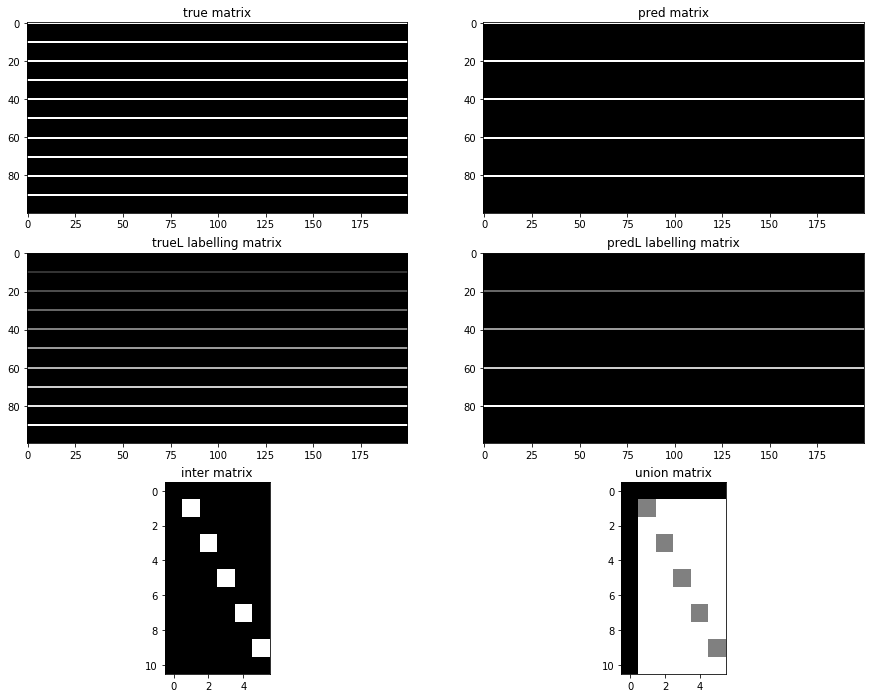

2017-11-12 02:26:36.351402


In [196]:
#
#
# 2017-11-12
#
# Пример использования:
#
#   строятся матрицы trueL, predL, inter, union
#   по ним находятся размеры и topleft для объектов
# 
#   По массиву inter можно найти объекты, которые имеют только нулевые пересечения
#   По массивам inter, union можно посчитать dice
#
# На матрицах 2048x2048 у меня работает около 40 секунд. 
# Отрисовку не делал.
#
# Мини-тестинг в конце notebook-а
#
#
#

import matplotlib.pyplot as plt

print (datetime.datetime.now())

tpi    = TruePredIntersect()

true   = np.zeros((100,200),dtype=np.uint8);
pred   = np.zeros(true.shape, dtype=np.uint8);

for rr in range(0,true.shape[0],10) : true[rr,:] = 1
for rr in range(0,true.shape[0],20) : pred[rr,:] = 1

trueL, predL, inter, union = tpi.intersect(true,pred);

trueS  = tpi.sizing(trueL)  # размеры объектов в true
trueTL = tpi.topleft(trueL) # top left объекта в true

predS  = tpi.sizing(predL)  # размеры объектов в pred
predTL = tpi.topleft(predL) # top left объекта в pred

print()
print('true objects = {} pred objects = {}'.format(len(trueS)-1,len(predS)-1))
print('true top left:',trueTL[1:].tolist())
print('pred top left:',predTL[1:].tolist())
print('true size    :',trueS[1:].tolist())
print('pred size    :',predS[1:].tolist())

trueEmpty = inter.sum(axis=1); 
print('true objects with empty intersection :', 
      [(ii,trueTL[ii].tolist()) for ii,ss in enumerate(trueEmpty) if ss==0 and ii>0])

plt.figure(figsize=(15,12))
plt.subplot(321); plt.imshow(true,'gray'); plt.title('true matrix')
plt.subplot(322); plt.imshow(pred,'gray'); plt.title('pred matrix')
plt.subplot(323); plt.imshow(trueL,'gray'); plt.title('trueL labelling matrix')
plt.subplot(324); plt.imshow(predL,'gray'); plt.title('predL labelling matrix')
plt.subplot(325); plt.imshow(inter,'gray'); plt.title('inter matrix')
plt.subplot(326); plt.imshow(union,'gray'); plt.title('union matrix')
plt.show()

print (datetime.datetime.now())

In [156]:
import unittest
##import matplotlib.pyplot as plt

class TestTruePredIntersect(unittest.TestCase) :
    
    #def setUp (self) :
    
    def test_empty (self) :
        true   = np.zeros((100,100));
        pred   = np.zeros(true.shape)
        tpi    = TruePredIntersect()
        trueL,predL,inter,union = tpi.intersect(true,pred)
        self.assertEqual (inter.shape,(1,1))
        self.assertEqual (union.shape,(1,1))
        self.assertEqual (trueL.shape,true.shape)
        self.assertEqual (predL.shape,pred.shape)

    def test_size (self) :
        true   = np.zeros((100,201));
        tpi    = TruePredIntersect()
        trueS = tpi.sizing(true)
        self.assertEqual (trueS.shape,(1,))
        self.assertEqual (trueS[0],true.shape[0]*true.shape[1])

        true   = np.zeros((100,201)); true[1,:] = 1
        trueS = tpi.sizing(true)
        self.assertEqual (trueS.shape,(2,))
        self.assertEqual (trueS[0],true.shape[0]*true.shape[1]-true.shape[1])
        self.assertEqual (trueS[1],true.shape[1])

        true   = np.zeros((100,201)); 
        true[1,:], true[3,:] = 1, 2
        trueS = tpi.sizing(true)
        self.assertEqual (trueS.shape,(3,))
        self.assertEqual (trueS[0],true.shape[0]*true.shape[1]-2*true.shape[1])
        self.assertEqual (trueS[1],true.shape[1])
        self.assertEqual (trueS[2],true.shape[1])

        true   = np.zeros((100,201)); 
        true[1,:], true[2,:], true[3,:] = 1, 1, 2
        trueS = tpi.sizing(true)
        self.assertEqual (trueS.shape,(3,))
        self.assertEqual (trueS[0],true.shape[0]*true.shape[1]-3*true.shape[1])
        self.assertEqual (trueS[1],2*true.shape[1])
        self.assertEqual (trueS[2],true.shape[1])

        
    def test_labelling (self) :
        true   = np.zeros((100,201));
        tpi    = TruePredIntersect()
        trueL = tpi.labelling(true)
        trueL0= tpi.labelling0(true)
        #plt.imshow(true); plt.show;
        self.assertEqual (trueL.shape, true.shape)
        self.assertEqual (trueL0.shape,true.shape)
        self.assertEqual (trueL.max(), 0)
        
        #self.assertEqual (trueS[0],true.shape[0]*true.shape[1])
        
        true   = np.zeros((100,201));
        true[0,:]  = 1
        trueL = tpi.labelling(true)
        self.assertEqual (trueL.max(), 1)
        
        true   = np.zeros((100,201));
        true[0,:]  = 1
        true[99,:] = 1
        trueL = tpi.labelling(true)
        self.assertEqual (trueL.max(), 2)

        true   = np.zeros((100,201));
        true[0,:]   = 1
        true[99,:]  = 1
        true[:,0]   = 1
        true[:,200] = 1
        trueL = tpi.labelling(true)
        self.assertEqual (trueL.max(), 1)

        true   = np.zeros((100,201));
        
        true[0,:]   = 1
        true[99,:]  = 1
        true[:,0]   = 1
        true[:,200] = 1
        
        true[0+4,:]   = 1
        true[99-4,:]  = 1
        true[:,0+4]   = 1
        true[:,200-4] = 1
        
        trueL = tpi.labelling(true)
        self.assertEqual (trueL.max(), 1)
        
        true   = np.zeros((100,201));
        
        res    = 0
        for dd in [0,4,8,10,20] :
            res += 1
            r1, r2 = 0+dd, true.shape[0]-dd-1
            c1, c2 = 0+dd, true.shape[1]-dd-1
            true[r1,c1:c2] = 1
            true[r2,c1:c2] = 1
            true[r1:r2,c1] = 1
            true[r1:r2,c2] = 1
        
        trueL = tpi.labelling(true)
        self.assertEqual (trueL.max(), res)
        
    def test_topleft (self) :
        
        true   = np.zeros((31,201));
        trueL = tpi.labelling(true)
        self.assertEqual (trueL.max(), 0)
        
        trueTL= tpi.topleft(trueL)
        self.assertEqual (trueTL.shape, (1,2)) # with 0
        self.assertEqual ((trueTL[0,0],trueTL[0,1]), (0,0)) # ???????
        
        true   = np.zeros((100,201));
        
        res    = 0
        listDD = [0,4,8,10,20]
        for dd in listDD :
            res += 1
            r1, r2 = 0+dd, true.shape[0]-dd-1
            c1, c2 = 0+dd, true.shape[1]-dd-1
            true[r1,c1:c2] = 1
            true[r2,c1:c2] = 1
            true[r1:r2,c1] = 1
            true[r1:r2,c2] = 1
        
        trueL = tpi.labelling(true)
        self.assertEqual (trueL.max(), res)
        
        trueTL= tpi.topleft(trueL)
        ##print(trueL.shape,trueL.max(),trueTL.shape, res)
        self.assertEqual (trueTL.shape, (res+1,2)) # with 0
        
        for ii,dd in enumerate(listDD) :
            self.assertEqual (trueTL[ii+1,0], dd)
            self.assertEqual (trueTL[ii+1,1], dd)
        

    def test_intersect(self) :
        
        # all empty
        true   = np.zeros((301,201));
        pred   = np.zeros(true.shape);
        res    = tpi.intersect(true, pred)
        self.assertEqual (len(res), 4)
        trueL, predL, inter, union = res
        self.assertEqual (trueL.shape, true.shape)
        self.assertEqual (predL.shape, pred.shape)
        self.assertEqual (inter.shape, (trueL.max()+1,predL.max()+1))
        self.assertEqual (union.shape, inter.shape)
        self.assertEqual (trueL.max(), 0)
        self.assertEqual (predL.max(), 0)
        self.assertEqual (inter[0,0], 0)
        self.assertEqual (union[0,0], 0)

        
        # true full, pred is empty
        true   = np.ones((200,200));
        pred   = np.zeros(true.shape);
        
        trueL, predL, inter, union = tpi.intersect(true, pred)
        self.assertEqual (trueL.shape, true.shape)
        self.assertEqual (predL.shape, pred.shape)
        self.assertEqual (inter.shape, (2,1))
        self.assertEqual (inter.shape, (trueL.max()+1,predL.max()+1))
        self.assertEqual (union.shape, inter.shape)
        self.assertEqual (trueL.max(), 1)
        self.assertEqual (predL.max(), 0)
        
        self.assertTrue ((inter==np.zeros(inter.shape)).all())
        self.assertEqual (union[0,0], 0)
        self.assertEqual (union[1,0], 0)
        
        # all full == 1
        true   = np.ones((200,200));
        pred   = np.ones(true.shape);
        
        trueL, predL, inter, union = tpi.intersect(true, pred, onlyNotZeros=True)
        self.assertEqual (trueL.shape, true.shape)
        self.assertEqual (predL.shape, pred.shape)
        self.assertEqual (inter.shape, (2,2))
        self.assertEqual (inter.shape, (trueL.max()+1,predL.max()+1))
        self.assertEqual (union.shape, inter.shape)
        self.assertEqual (trueL.max(), 1)
        self.assertEqual (predL.max(), 1)
        
        self.assertTrue ((union==inter).all())
        self.assertEqual (union[0,0], 0)
        self.assertEqual (union[1,0], 0)
        self.assertEqual (union[0,1], 0)
        self.assertEqual (union[1,1], true.shape[0]*true.shape[1])
        
        # true full == 1, pred on center = 1 (not center, inner true)
        true   = np.ones((200,200));
        pred   = np.zeros(true.shape);
        
        pred[10:200-10,10:200-10] = 1; # intersection == 180*180
        
        trueL, predL, inter, union = tpi.intersect(true, pred, onlyNotZeros=True)
        self.assertEqual (trueL.shape, true.shape)
        self.assertEqual (predL.shape, pred.shape)
        self.assertEqual (inter.shape, (2,2))
        self.assertEqual (inter.shape, (trueL.max()+1,predL.max()+1))
        self.assertEqual (union.shape, inter.shape)
        self.assertEqual (trueL.max(), 1)
        self.assertEqual (predL.max(), 1)
        
        self.assertEqual (inter[0,0], 0)
        self.assertEqual (inter[1,0], 0)
        self.assertEqual (inter[0,1], 0)
        self.assertEqual (inter[1,1], 180*180)
        self.assertEqual (union[0,0], 0)
        self.assertEqual (union[1,0], 0)
        self.assertEqual (union[0,1], 0)
        self.assertEqual (union[1,1], true.shape[0]*true.shape[1])
        
        # true center == 1, pred = 1 in top left and down right. Intersection == 1 both case 
        true   = np.zeros((200,200));
        pred   = np.zeros(true.shape);
        
        true[10:200-10+1, 10:200-10+1] = 1; #
        pred[0:11, 0:11] = 1
        pred[200-10:200,200-10:200] =1
        
        trueL, predL, inter, union = tpi.intersect(true, pred, onlyNotZeros=True)
        
        ##print(trueL.max(), predL.max())
        
        self.assertEqual (inter.shape, (2,3))
        self.assertEqual (inter.shape, (trueL.max()+1,predL.max()+1))
        self.assertEqual (union.shape, inter.shape)
        self.assertEqual (trueL.max(), 1)
        self.assertEqual (predL.max(), 2)
        
        self.assertEqual (inter[0,0], 0)
        self.assertEqual (inter[1,0], 0)
        self.assertEqual (inter[0,1], 0)
        self.assertEqual (inter[0,2], 0)
        self.assertEqual (inter[1,1], 1)
        self.assertEqual (inter[1,2], inter[1,1])
        
        self.assertEqual (union[0,0], 0)
        self.assertEqual (union[1,0], 0)
        self.assertEqual (union[0,1], 0)
        self.assertEqual (union[0,2], 0)
        self.assertEqual (union[1,1], 181*181+11*11-1)
        self.assertEqual (union[1,2], 181*181+10*10-1)
        
        # true center == 1, pred = 1 in top left and down left. Intersection == 1 both case 
        true   = np.zeros((200,200));
        pred   = np.zeros(true.shape);
        
        true[10:200-10+1, 10:200-10+1] = 1; #
        pred[0:11, 0:11] = 1
        pred[200-10:200,0:11] =1
        
        trueL, predL, inter, union = tpi.intersect(true, pred, onlyNotZeros=True)
        
        ##print(trueL.max(), predL.max())
        
        self.assertEqual (inter.shape, (2,3))
        self.assertEqual (inter.shape, (trueL.max()+1,predL.max()+1))
        self.assertEqual (union.shape, inter.shape)
        self.assertEqual (trueL.max(), 1)
        self.assertEqual (predL.max(), 2)
        
        self.assertEqual (inter[0,0], 0)
        self.assertEqual (inter[1,0], 0)
        self.assertEqual (inter[0,1], 0)
        self.assertEqual (inter[0,2], 0)
        self.assertEqual (inter[1,1], 1)
        self.assertEqual (inter[1,2], 1)
        
        self.assertEqual (union[0,0], 0)
        self.assertEqual (union[1,0], 0)
        self.assertEqual (union[0,1], 0)
        self.assertEqual (union[0,2], 0)
        self.assertEqual (union[1,1], 181*181+11*11-1)
        self.assertEqual (union[1,2], 181*181+10*11-1)
        
        
    
rc = unittest.main(argv=['first-arg-is-ignored'], exit=False); #print(rc)

.....
----------------------------------------------------------------------
Ran 5 tests in 4.246s

OK
